In [1]:
#Base Imports
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Pre Processing Imports
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#Model Building Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Embedding, Dropout, GRU #Activation, Flatten, Input, GRU , Bidirectional#  concatenate, #GlobalMaxPooling1D, MaxPooling1D
#Model Evaluation imports
from sklearn import metrics
from sklearn.metrics import (classification_report,confusion_matrix , 
                             precision_recall_curve ,precision_score,recall_score , accuracy_score,SCORERS)


 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('emotions_preprocessed.csv')

In [3]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def remove_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def remove_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def clean(df):
    
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : remove_numbers(text))
    df.text=df.text.apply(lambda text : remove_punctuations(text))
    df.text=df.text.apply(lambda text : remove_urls(text))
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df




  

In [4]:
df = clean(df)
df

,text,labels
0,my favourite food anything i cook myself,1
1,now himself everyone think he laugh screwing p...,1
2,why the fuck is bayless isoing,12
3,to make feel threatened,7
4,dirty southern wanker,12
...,...,...
53989,it s pretty dangerous state decides fictional ...,7
53990,i filed divorce morning hoping move next day so,11
53991,the last time happened i said no closed door,13
53992,i can’t stand arrogant prick he’s better thenf...,12


## 1ST SPLIT 90/5/5

In [5]:
X= df.text
y= df.labels
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.1, random_state=70)
X_val,X_test,y_val,y_test= train_test_split(X_other,y_other,test_size=0.5,random_state=70)

In [6]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train], axis=0))
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
max_len = max([len(t) for t in X_train])
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')
vocabSize = len(tokenizer.index_word) + 1

#Text Representation Using Glove Embedding 
path_to_glove_file = 'glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300
embeddings_index = {}
misses=0
hits=0


with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

#define early stopping to control overfitting
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

Found 37231 word vectors.
Converted 13684 words (11651 misses)


In [7]:
gru_model = Sequential()
gru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(14, activation='softmax'))
gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 531, 300)          7600800   
                                                                 
 gru (GRU)                   (None, 531, 64)           70272     
                                                                 
 dropout (Dropout)           (None, 531, 64)           0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 14)                462       
                                                                 
Total params: 7,680,942
Trainable params: 80,142
Non-tra

In [8]:
gru_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [9]:
# Fit model
history_gru=gru_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
190/190 [==============================] - 21s 60ms/step - loss: 2.2238 - accuracy: 0.3397 - val_loss: 1.8817 - val_accuracy: 0.4407
Epoch 2/30
190/190 [==============================] - 11s 56ms/step - loss: 1.9140 - accuracy: 0.4324 - val_loss: 1.7627 - val_accuracy: 0.4830
Epoch 3/30
190/190 [==============================] - 11s 56ms/step - loss: 1.8275 - accuracy: 0.4591 - val_loss: 1.6942 - val_accuracy: 0.4952
Epoch 4/30
190/190 [==============================] - 11s 57ms/step - loss: 1.7689 - accuracy: 0.4740 - val_loss: 1.6619 - val_accuracy: 0.5056
Epoch 5/30
190/190 [==============================] - 11s 57ms/step - loss: 1.7325 - accuracy: 0.4848 - val_loss: 1.6335 - val_accuracy: 0.5104
Epoch 6/30
190/190 [==============================] - 11s 58ms/step - loss: 1.7006 - accuracy: 0.4927 - val_loss: 1.6126 - val_accuracy: 0.5107
Epoch 7/30
190/190 [==============================] - 11s 58ms/step - loss: 1.6774 - accuracy: 0.4982 - val_loss: 1.6014 - val_accuracy:

In [10]:
gru_y_pred = gru_model.predict(X_test)
gru_y_pred_labels = np.argmax(gru_y_pred, axis=1)
gru_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(gru_y_test_labels, gru_y_pred_labels))


85/85 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0       0.47      0.79      0.59       763
           1       0.53      0.20      0.29       195
           2       0.43      0.36      0.39        90
           3       0.61      0.38      0.47        53
           4       0.45      0.11      0.17       168
           5       0.61      0.63      0.62       278
           6       0.53      0.54      0.53        52
           7       0.77      0.81      0.79       134
           8       0.54      0.38      0.45       206
           9       0.35      0.25      0.29        91
          10       0.56      0.44      0.49       144
          11       0.47      0.38      0.42       252
          12       0.33      0.10      0.15       136
          13       0.50      0.56      0.53       138

    accuracy                           0.51      2700
   macro avg       0.51      0.42      0.44      2700
weighted avg       0.51   

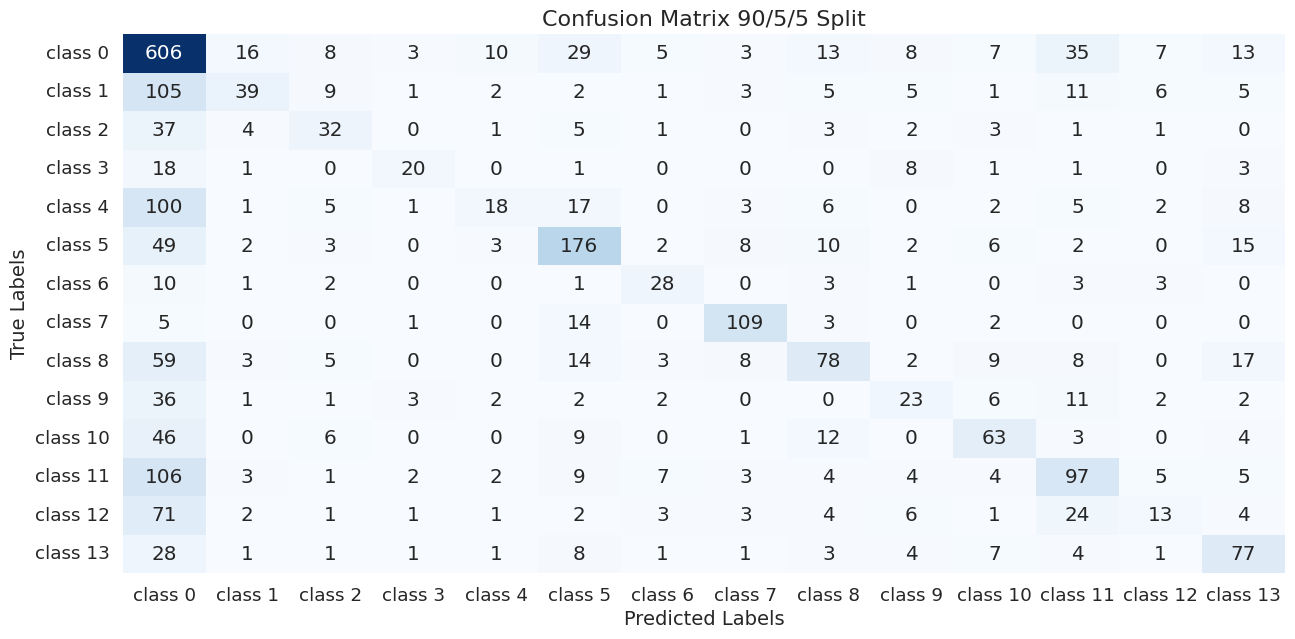

In [11]:
conf_mat_gru = confusion_matrix(gru_y_test_labels, gru_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_gru, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix 90/5/5 Split', fontsize=16)
plt.show()

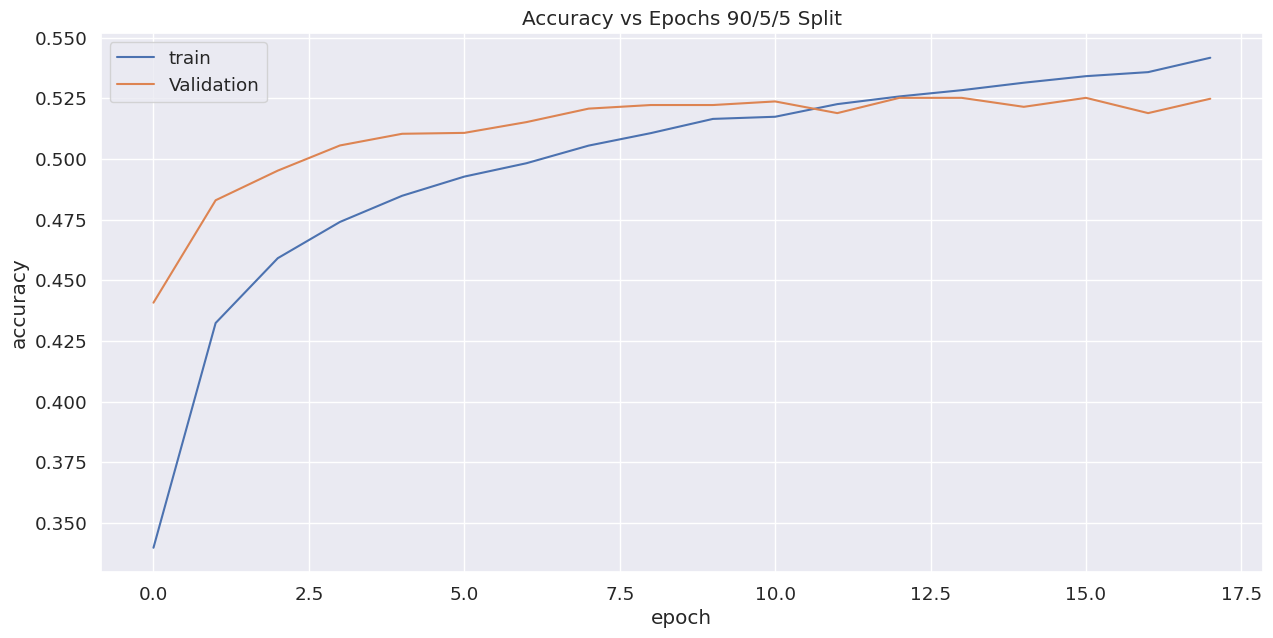

In [12]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Accuracy vs Epochs 90/5/5 Split')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

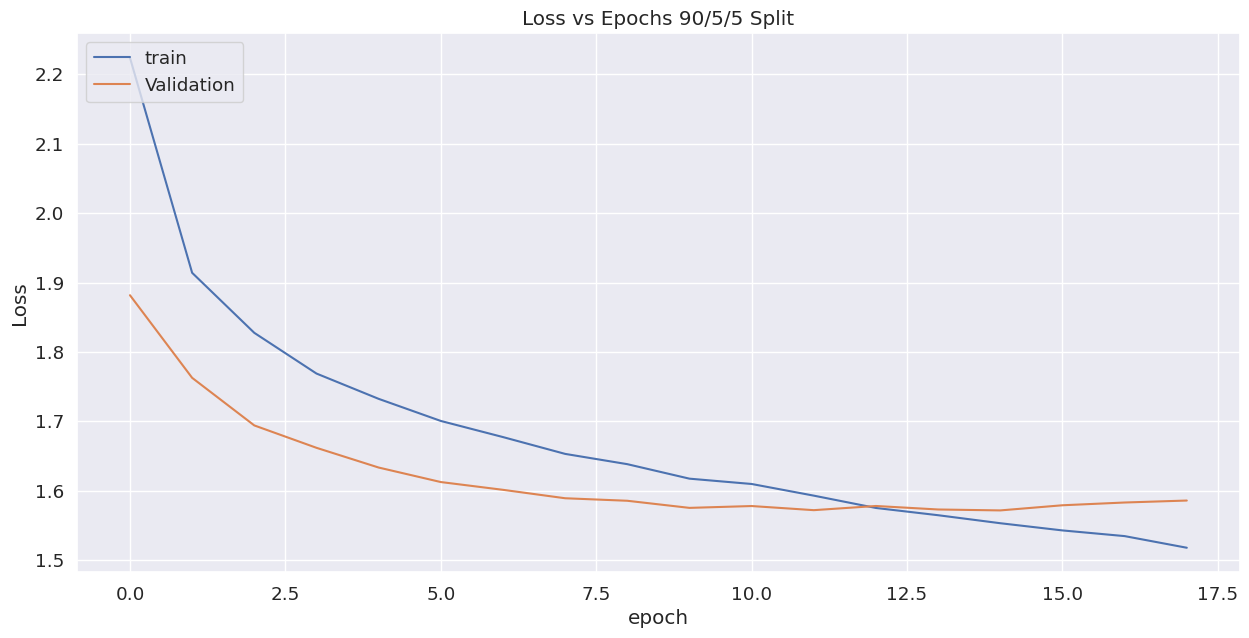

In [13]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Loss vs Epochs 90/5/5 Split')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## 2ND SPLIT 10/45/45

In [14]:
X= df.text
y= df.labels
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.9, random_state=70)
X_val,X_test,y_val,y_test= train_test_split(X_other,y_other,test_size=0.5,random_state=70)

In [15]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train], axis=0))
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
max_len = max([len(t) for t in X_train])
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')
vocabSize = len(tokenizer.index_word) + 1

#Text Representation Using Glove Embedding 
path_to_glove_file = 'glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300
embeddings_index = {}
misses=0
hits=0


with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

#define early stopping to control overfitting
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

Found 61159 word vectors.
Converted 6259 words (1483 misses)


In [16]:
gru_model = Sequential()
gru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(14, activation='softmax'))
gru_model.summary()
gru_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 140, 300)          2322900   
                                                                 
 gru_2 (GRU)                 (None, 140, 64)           70272     
                                                                 
 dropout_2 (Dropout)         (None, 140, 64)           0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 14)                462       
                                                                 
Total params: 2,403,042
Trainable params: 80,142
Non-t

In [17]:
# Fit model
history_gru=gru_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
22/22 [==============================] - 6s 87ms/step - loss: 2.4794 - accuracy: 0.2493 - val_loss: 2.3368 - val_accuracy: 0.3081
Epoch 2/30
22/22 [==============================] - 2s 78ms/step - loss: 2.3570 - accuracy: 0.2949 - val_loss: 2.2740 - val_accuracy: 0.3264
Epoch 3/30
22/22 [==============================] - 1s 53ms/step - loss: 2.2868 - accuracy: 0.3239 - val_loss: 2.2061 - val_accuracy: 0.3490
Epoch 4/30
22/22 [==============================] - 2s 80ms/step - loss: 2.2142 - accuracy: 0.3449 - val_loss: 2.1364 - val_accuracy: 0.3639
Epoch 5/30
22/22 [==============================] - 1s 50ms/step - loss: 2.1558 - accuracy: 0.3571 - val_loss: 2.0823 - val_accuracy: 0.3780
Epoch 6/30
22/22 [==============================] - 1s 50ms/step - loss: 2.0834 - accuracy: 0.3780 - val_loss: 2.0186 - val_accuracy: 0.4003
Epoch 7/30
22/22 [==============================] - 1s 50ms/step - loss: 2.0293 - accuracy: 0.3991 - val_loss: 1.9718 - val_accuracy: 0.4116
Epoch 8/30
22

In [18]:
gru_y_pred = gru_model.predict(X_test)
gru_y_pred_labels = np.argmax(gru_y_pred, axis=1)
gru_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(gru_y_test_labels, gru_y_pred_labels))

760/760 [==============================] - 4s 5ms/step
              precision    recall  f1-score   support

           0       0.43      0.83      0.57      7134
           1       0.34      0.01      0.02      1683
           2       0.25      0.00      0.00       813
           3       0.42      0.03      0.05       512
           4       0.13      0.00      0.01      1516
           5       0.52      0.63      0.57      2338
           6       0.30      0.10      0.15       476
           7       0.75      0.80      0.77      1206
           8       0.44      0.29      0.35      1799
           9       0.36      0.27      0.31       834
          10       0.51      0.31      0.38      1264
          11       0.36      0.39      0.38      2035
          12       0.16      0.02      0.03      1330
          13       0.54      0.45      0.49      1358

    accuracy                           0.46     24298
   macro avg       0.39      0.30      0.29     24298
weighted avg       0.41  

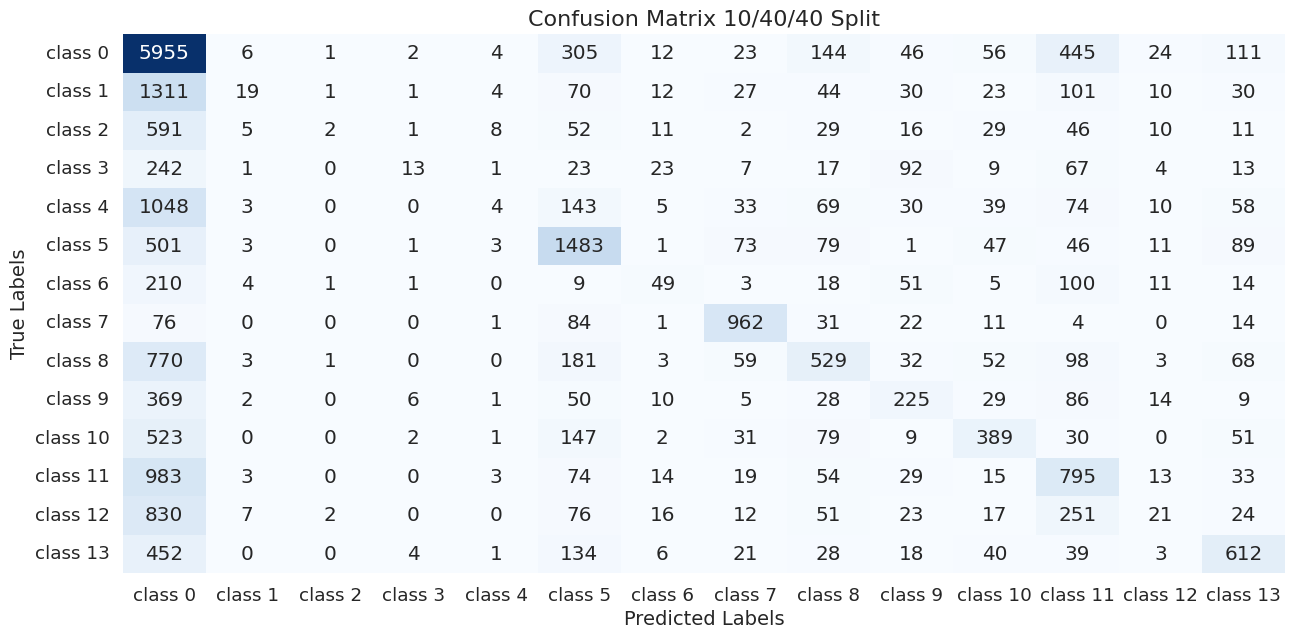

In [19]:
conf_mat_gru = confusion_matrix(gru_y_test_labels, gru_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_gru, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix 10/40/40 Split', fontsize=16)
plt.show()

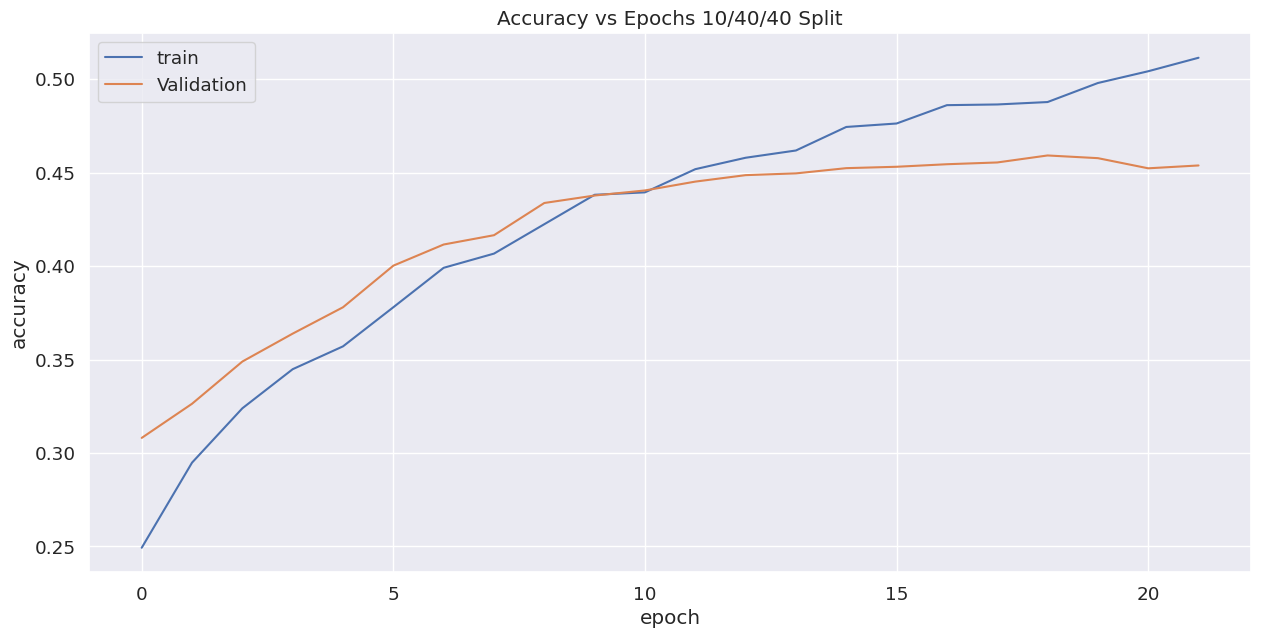

In [20]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Accuracy vs Epochs 10/40/40 Split')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

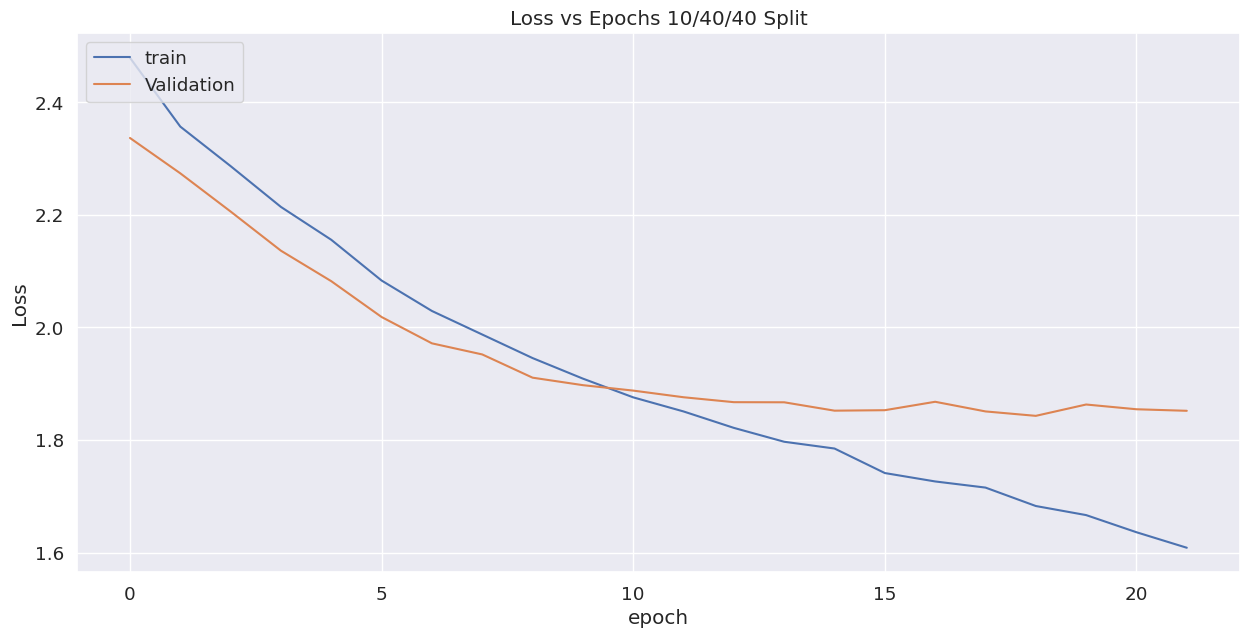

In [21]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Loss vs Epochs 10/40/40 Split')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## 3RD SPLIT 25/25/50

In [22]:
X= df.text
y= df.labels
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.75, random_state=70)
X_val,X_test,y_val,y_test= train_test_split(X_other,y_other,test_size=0.33,random_state=70)

In [23]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train], axis=0))
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
max_len = max([len(t) for t in X_train])
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')
vocabSize = len(tokenizer.index_word) + 1

#Text Representation Using Glove Embedding 
path_to_glove_file = 'glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300
embeddings_index = {}
misses=0
hits=0


with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

#define early stopping to control overfitting
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

Found 65215 word vectors.
Converted 9880 words (3161 misses)


In [24]:
gru_model = Sequential()
gru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(14, activation='softmax'))
gru_model.summary()
gru_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 145, 300)          3912600   
                                                                 
 gru_4 (GRU)                 (None, 145, 64)           70272     
                                                                 
 dropout_4 (Dropout)         (None, 145, 64)           0         
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 14)                462       
                                                                 
Total params: 3,992,742
Trainable params: 80,142
Non-t

In [25]:
# Fit model
history_gru=gru_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
53/53 [==============================] - 6s 48ms/step - loss: 2.4337 - accuracy: 0.2614 - val_loss: 2.2699 - val_accuracy: 0.3338
Epoch 2/30
53/53 [==============================] - 2s 32ms/step - loss: 2.2260 - accuracy: 0.3412 - val_loss: 2.0427 - val_accuracy: 0.3881
Epoch 3/30
53/53 [==============================] - 2s 42ms/step - loss: 2.0578 - accuracy: 0.3868 - val_loss: 1.9234 - val_accuracy: 0.4231
Epoch 4/30
53/53 [==============================] - 2s 43ms/step - loss: 1.9803 - accuracy: 0.4136 - val_loss: 1.8669 - val_accuracy: 0.4399
Epoch 5/30
53/53 [==============================] - 2s 42ms/step - loss: 1.9113 - accuracy: 0.4327 - val_loss: 1.8265 - val_accuracy: 0.4543
Epoch 6/30
53/53 [==============================] - 2s 32ms/step - loss: 1.8709 - accuracy: 0.4500 - val_loss: 1.8102 - val_accuracy: 0.4587
Epoch 7/30
53/53 [==============================] - 2s 33ms/step - loss: 1.8305 - accuracy: 0.4580 - val_loss: 1.7662 - val_accuracy: 0.4705
Epoch 8/30
53

In [26]:
gru_y_pred = gru_model.predict(X_test)
gru_y_pred_labels = np.argmax(gru_y_pred, axis=1)
gru_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(gru_y_test_labels, gru_y_pred_labels))

418/418 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.45      0.86      0.59      3953
           1       0.41      0.04      0.08       940
           2       0.55      0.14      0.22       461
           3       0.61      0.18      0.28       302
           4       0.28      0.06      0.10       794
           5       0.59      0.65      0.61      1218
           6       0.44      0.23      0.30       268
           7       0.78      0.80      0.79       691
           8       0.54      0.34      0.42      1010
           9       0.42      0.32      0.37       459
          10       0.50      0.37      0.42       696
          11       0.45      0.35      0.40      1125
          12       0.22      0.01      0.02       701
          13       0.57      0.50      0.53       746

    accuracy                           0.49     13364
   macro avg       0.49      0.35      0.37     13364
weighted avg       0.48  

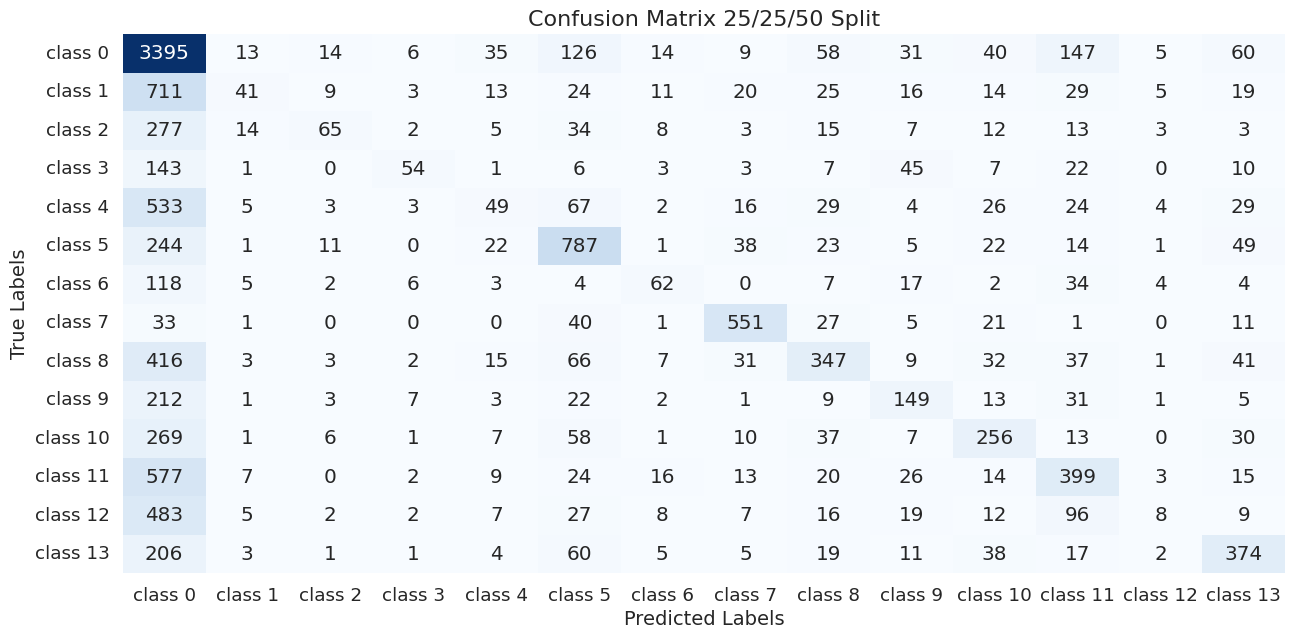

In [27]:
conf_mat_gru = confusion_matrix(gru_y_test_labels, gru_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_gru, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix 25/25/50 Split', fontsize=16)
plt.show()


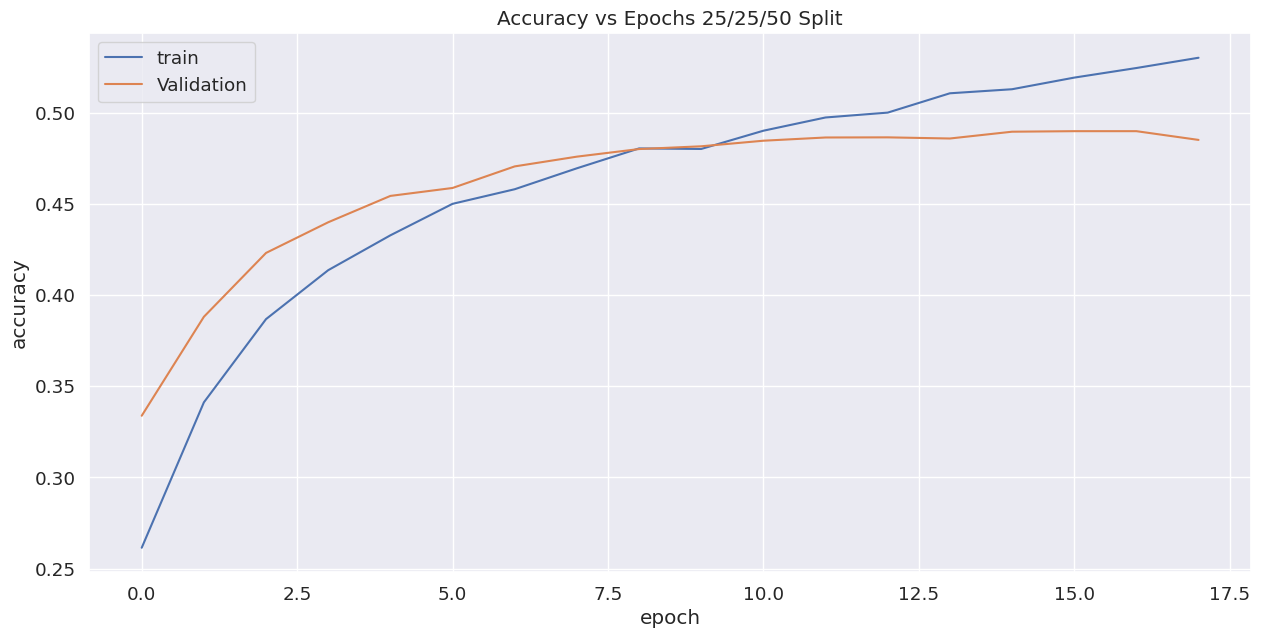

In [28]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Accuracy vs Epochs 25/25/50 Split')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

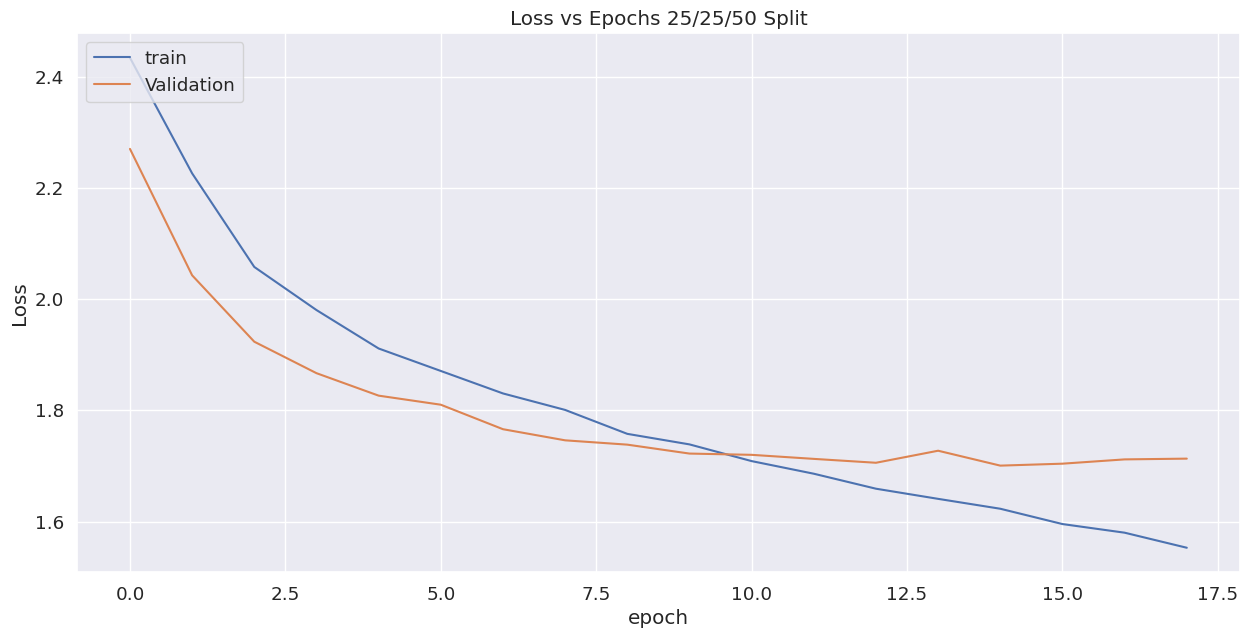

In [29]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Loss vs Epochs 25/25/50 Split')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## 4TH SPLIT 25/50/25

In [30]:
X= df.text
y= df.labels
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.75, random_state=70)
X_val,X_test,y_val,y_test= train_test_split(X_other,y_other,test_size=0.67,random_state=70)

In [31]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train], axis=0))
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
max_len = max([len(t) for t in X_train])
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')
vocabSize = len(tokenizer.index_word) + 1

#Text Representation Using Glove Embedding 
path_to_glove_file = 'glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300
embeddings_index = {}
misses=0
hits=0


with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

#define early stopping to control overfitting
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

Found 69272 word vectors.
Converted 9970 words (3071 misses)


In [32]:
gru_model = Sequential()
gru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(14, activation='softmax'))
gru_model.summary()
gru_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 145, 300)          3912600   
                                                                 
 gru_6 (GRU)                 (None, 145, 64)           70272     
                                                                 
 dropout_6 (Dropout)         (None, 145, 64)           0         
                                                                 
 gru_7 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 14)                462       
                                                                 
Total params: 3,992,742
Trainable params: 80,142
Non-t

In [33]:
# Fit model
history_gru=gru_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
53/53 [==============================] - 6s 45ms/step - loss: 2.4354 - accuracy: 0.2721 - val_loss: 2.2576 - val_accuracy: 0.3222
Epoch 2/30
53/53 [==============================] - 1s 25ms/step - loss: 2.2312 - accuracy: 0.3353 - val_loss: 2.0779 - val_accuracy: 0.3623
Epoch 3/30
53/53 [==============================] - 2s 30ms/step - loss: 2.0886 - accuracy: 0.3777 - val_loss: 1.9588 - val_accuracy: 0.4100
Epoch 4/30
53/53 [==============================] - 1s 27ms/step - loss: 1.9850 - accuracy: 0.4132 - val_loss: 1.8693 - val_accuracy: 0.4432
Epoch 5/30
53/53 [==============================] - 1s 26ms/step - loss: 1.9139 - accuracy: 0.4347 - val_loss: 1.8175 - val_accuracy: 0.4607
Epoch 6/30
53/53 [==============================] - 1s 25ms/step - loss: 1.8628 - accuracy: 0.4495 - val_loss: 1.7857 - val_accuracy: 0.4682
Epoch 7/30
53/53 [==============================] - 2s 30ms/step - loss: 1.8301 - accuracy: 0.4612 - val_loss: 1.7681 - val_accuracy: 0.4726
Epoch 8/30
53

In [34]:
gru_y_pred = gru_model.predict(X_test)
gru_y_pred_labels = np.argmax(gru_y_pred, axis=1)
gru_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(gru_y_test_labels, gru_y_pred_labels))

848/848 [==============================] - 5s 6ms/step
              precision    recall  f1-score   support

           0       0.46      0.81      0.59      8047
           1       0.44      0.07      0.12      1879
           2       0.47      0.15      0.23       908
           3       0.46      0.20      0.28       581
           4       0.32      0.01      0.02      1635
           5       0.61      0.62      0.62      2597
           6       0.47      0.30      0.37       562
           7       0.77      0.83      0.80      1382
           8       0.51      0.38      0.43      2015
           9       0.34      0.35      0.34       871
          10       0.51      0.39      0.44      1418
          11       0.40      0.44      0.42      2286
          12       0.36      0.03      0.05      1455
          13       0.51      0.56      0.53      1497

    accuracy                           0.49     27133
   macro avg       0.47      0.37      0.37     27133
weighted avg       0.48  

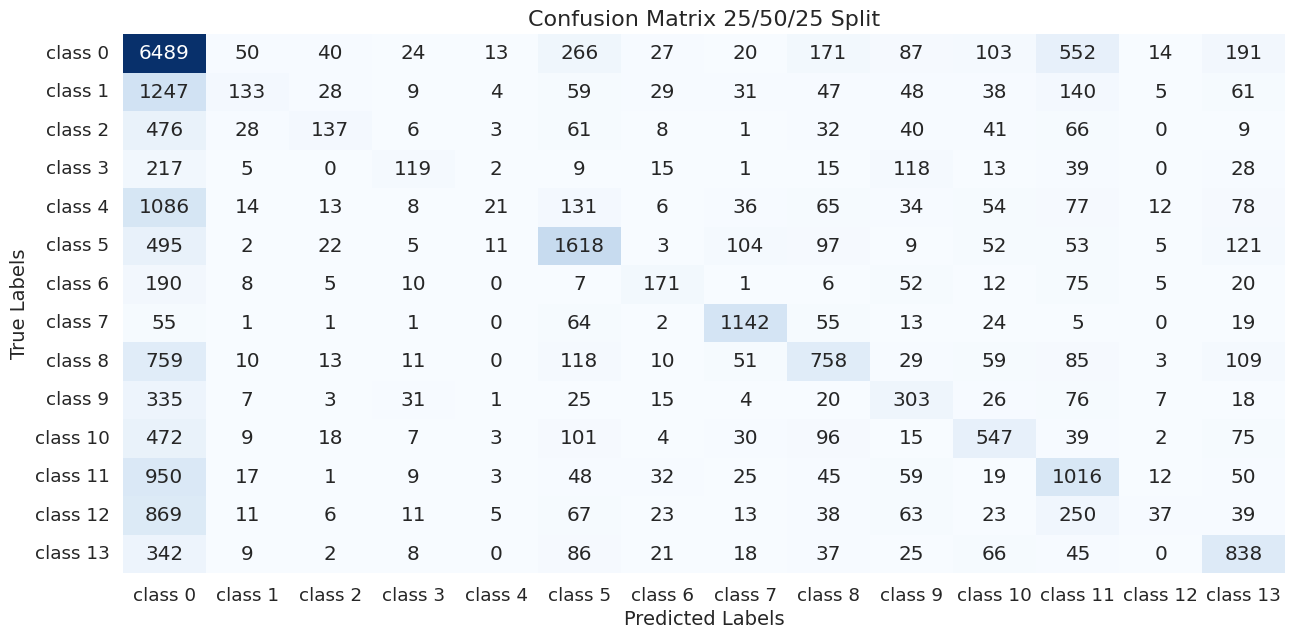

In [35]:
conf_mat_gru = confusion_matrix(gru_y_test_labels, gru_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_gru, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix 25/50/25 Split', fontsize=16)
plt.show()


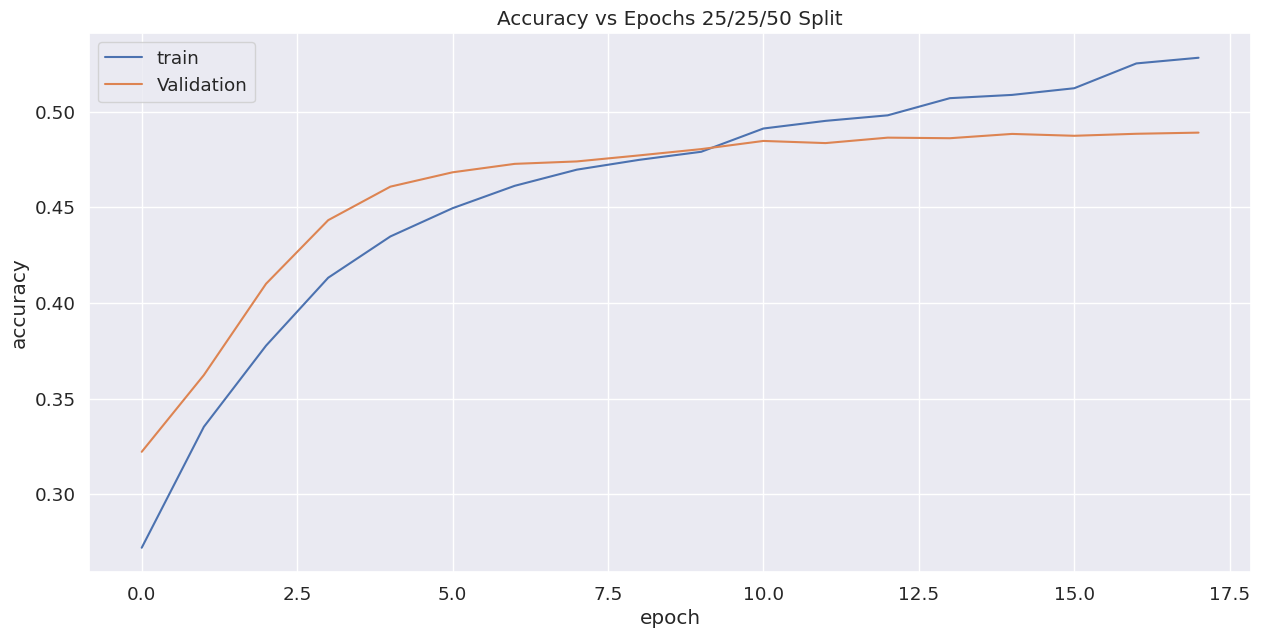

In [36]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Accuracy vs Epochs 25/25/50 Split')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

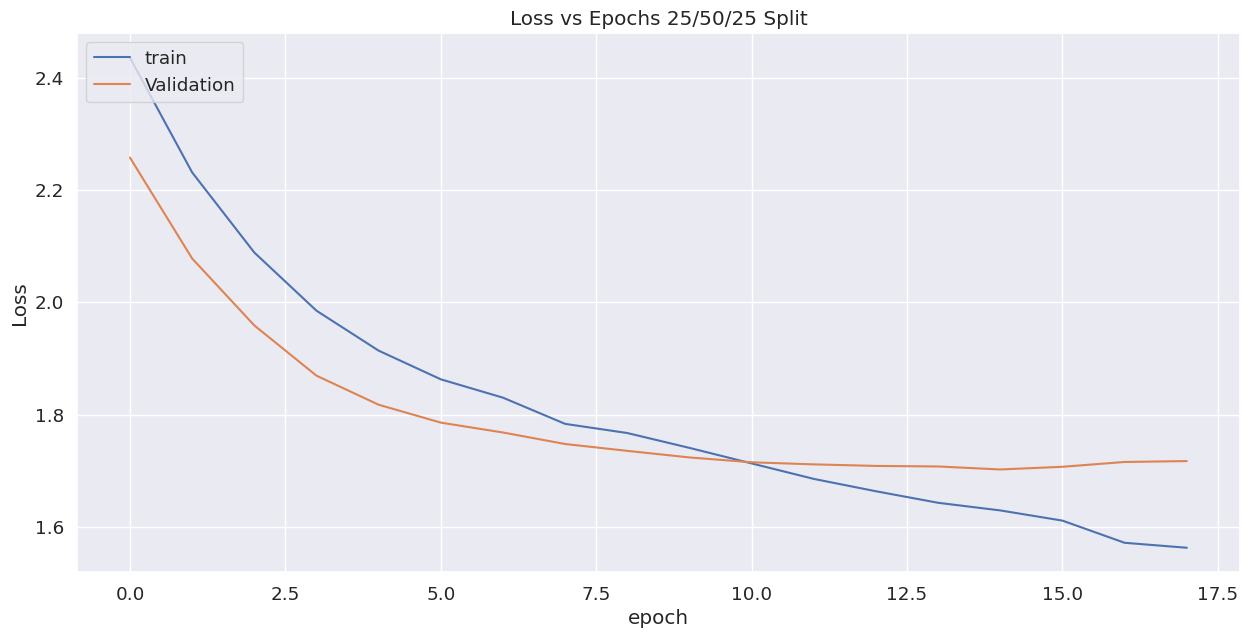

In [37]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Loss vs Epochs 25/50/25 Split')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2ae8d1f9-debd-4ea4-90f5-a7c1ed63f6e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>